# Spray Glider - Automated Spatial Scales Analysis for the total currents 

**Purpose**: Code for computing the autocorrelation function along a spray glider transect for the Total Current

**Luke Colosi | lcolosi@ucsd.edu**

Force matplotlib plots to display directly within the output cell of the notebook: 

In [1]:
%matplotlib inline

Supress decrepation warnings

In [2]:
import warnings

# Suppress specific category of warnings (e.g., deprecation warnings)
warnings.filterwarnings("ignore")


Import python libraries


In [3]:
#--- Build-in Python Functions ---# 
import numpy as np
import xarray as xr
import matplotlib.pyplot as plt
from netCDF4 import Dataset, num2date
from datetime import datetime
import pandas as pd
import cartopy.crs as ccrs
import sys
import os
import matplotlib 
from geopy.distance import geodesic
import cftime
import matplotlib.dates as mdates
from scipy.interpolate import interp1d
from scipy.integrate import trapezoid
from scipy import stats
import gsw

# Set path to access python functions
sys.path.append('/Users/lukecolosi/Desktop/projects/graduate_research/Gille_lab/AirSeaCoupling/tools/')

#--- Luke's Python Functions ---# 
import cartopy_figs as cart
from autocorr import compute_autocorr, decor_scale, compute_glider_autocorr, compute_glider_autocorr_complex
from lsf import detrend
from plotScaleAnalysis import plot_depth_temp_transect

Set data analysis parameters

In [4]:
years_d      = ['2022','2023']    # Year(s) to analyze 
season       = 'all'

Load spray glider and intermediate data products (**NOTE**:  The intermediate data have the same profile coordinate as the spray glider data and have the same mask as the longitude and latitude from the spray glider data)

In [5]:
# Set path to project directory
PATH = "/Users/lukecolosi/Desktop/projects/graduate_research/Gille_lab/AirSeaCoupling"

#--- Spray Glider Data ---# 
filename_sg = PATH + "/data/spray_gliders/CUGN_line_80.nc"
nc = Dataset(filename_sg, 'r')

# Extract data variables
profile = nc.variables['profile'][:]
depth   = nc.variables['depth'][:]

lon = nc.variables['lon_uv'][:]
lat = nc.variables['lat_uv'][:]
time =  num2date(nc.variables['time_uv'][:], nc.variables['time_uv'].units)

u = nc.variables['u'][:]
v = nc.variables['v'][:]

#--- Intermediate Data ---# 
filename_int = PATH + "/data/spray_gliders/CUGN_line_80_intermediate_data.nc"
nc = Dataset(filename_int, 'r')

# Extract data variables
dist           = nc.variables['DIST_uv'][:]
water_depth    = nc.variables['WATER_DEPTH_uv'][:]
Pressure       = nc.variables['Pressure'][:]
SA             = nc.variables['ASal'][:]
CT             = nc.variables['CTemp'][:]
sigma0         = nc.variables['SIG'][:]
Nsquared       = nc.variables['N2'][:]
Time           = nc.variables['TIME'][:]

Now grab velocity data from multiple years and depth average

In [6]:
# Grab temperature, salinity, horizontal velocities from a given depth 
depth_lim = 100 # Units: meters
u_dp = np.ma.mean(u[(depth >= depth[0]) & (depth <= depth_lim),:].T,axis=1)
v_dp = np.ma.mean(v[(depth >= depth[0]) & (depth <= depth_lim),:].T,axis=1)

# Grab indices of masked elements 
time_mask = np.array(np.where(time.mask))
lon_mask  = np.array(np.where(lon.mask))
lat_mask  = np.array(np.where(lat.mask))

# Check if the masked elements in time, lon, and lat 
if (time_mask == lon_mask).all() and (time_mask == lat_mask).all() and (lon_mask == lat_mask).all():

    # Combine masks from time and temperature 
    vel_mask = np.logical_or(u_dp.mask,time.mask)

    # Mask temperature, time, lon, and lat on the new mask 
    u_m = np.ma.masked_where(vel_mask,u_dp)
    v_m = np.ma.masked_where(vel_mask,v_dp)
    time_m = np.ma.masked_where(vel_mask,time)
    lon_m  = np.ma.masked_where(vel_mask,lon)
    lat_m  = np.ma.masked_where(vel_mask,lat)
    dist_m = np.ma.masked_where(vel_mask,dist)
    water_depth_m = np.ma.masked_where(vel_mask,water_depth)

    # Removed Masked values 
    u_m_cn = u_m.compressed()
    v_m_cn = v_m.compressed()
    time_m_cn = time_m.compressed()
    lon_m_cn  = lon_m.compressed()
    lat_m_cn  = lat_m.compressed()
    dist_m_cn   = dist_m.compressed()
    water_depth_m_cn = water_depth_m.compressed()

    # Grab the years from the cleaned time array 
    years  = np.array([y.year for y in time_m_cn])

    # Initialize year array 
    u_t           = []
    v_t           = []
    time_t        = []
    lon_t         = []
    lat_t         = []
    dist_t        = []
    water_depth_t = []

    # Loop through years 
    for iyear in range(0,len(years_d)):

        # Find indices for ith year
        year_idx = years == int(years_d[iyear]) 

        # Obtain time steps from ith year
        u_t.extend(u_m_cn[year_idx])
        v_t.extend(v_m_cn[year_idx])
        time_t.extend(time_m_cn[year_idx])
        lon_t.extend(lon_m_cn[year_idx])
        lat_t.extend(lat_m_cn[year_idx])
        dist_t.extend(dist_m_cn[year_idx])
        water_depth_t.extend(water_depth_m_cn[year_idx])

# Convert variables to numpy arrays 
u_t        = np.ma.array(u_t)
v_t        = np.ma.array(v_t)
time_t        = np.ma.array(time_t)
lon_t         = np.ma.array(lon_t)
lat_t         = np.ma.array(lat_t)
dist_t        = np.ma.array(dist_t)
water_depth_t = np.ma.array(water_depth_t)

Convert cftime.DatetimeGregorian to Python datetime objects

In [7]:
time_dt = np.array([datetime(d.year, d.month, d.day, d.hour, d.minute, d.second) for d in time_t])

Spilt up the legs of the glider trajectory 

In [8]:
# Compute a moving mean filter (to smooth small fluctuations in the trajectory especially during turns)
window_size = 20
dist_sm = np.convolve(dist_t, np.ones(window_size)/window_size, mode='same')

# Compute the distance between consecutive points traversed relative to shore (positive = moving off-shore, negative = moving on-shore) 
# and use prepend to ensure dist_diff is the same length as dist_t and dist_sm (first element is the difference between dist_sm[0] and dist_sm[0]) = 0
# which essentially means the glider starts from a stationary point)
dist_diff = np.diff(dist_sm, prepend = dist_sm[0]) 

# Determine direction by creating an array where points satisfying the off-shore condition are labeled as 1 and false elements are labeled as -1 
# (offshore = 1, onshore = -1)
direction = np.where(dist_diff > 0, 1, -1)

#--- Identify transition points ---#

# Get indicies where the direction changes 
transitions = np.where(np.diff(direction) != 0)[0] + 1  

# Initialize an array of segment labels (will later be assigned values based on offshore/onshore transitions)
segments = np.zeros_like(dist_t, dtype=int) 

# Initialize segment label loop variable 
segment_id = 0

# Loop through segment identified by transition 
for i in range(len(transitions) - 1):

    # Assign segment labels 
    segments[transitions[i]:transitions[i + 1]] = segment_id

    # Increment segment label 
    segment_id += 1

#--- Remove short segments ---# 

# Count occurrences of each segment
segment_lengths = np.bincount(segments) 

# Set threshold for segment length (80 = only long transects, 50 = long and short transects)
min_segment_size = 93

# Identify valid transects labels 
valid_segments = np.where(segment_lengths >= min_segment_size)[0]

#--- Filter out short segments ---# 
mask = np.isin(segments, valid_segments)
time_seg = time_dt[mask]
dist_seg = dist_t[mask]
u_seg = u_t[mask]
v_seg = v_t[mask]
water_depth_seg = water_depth_t[mask]
segment_labels = segments[mask]
direction_seg = direction[mask]

Plot segmentation results

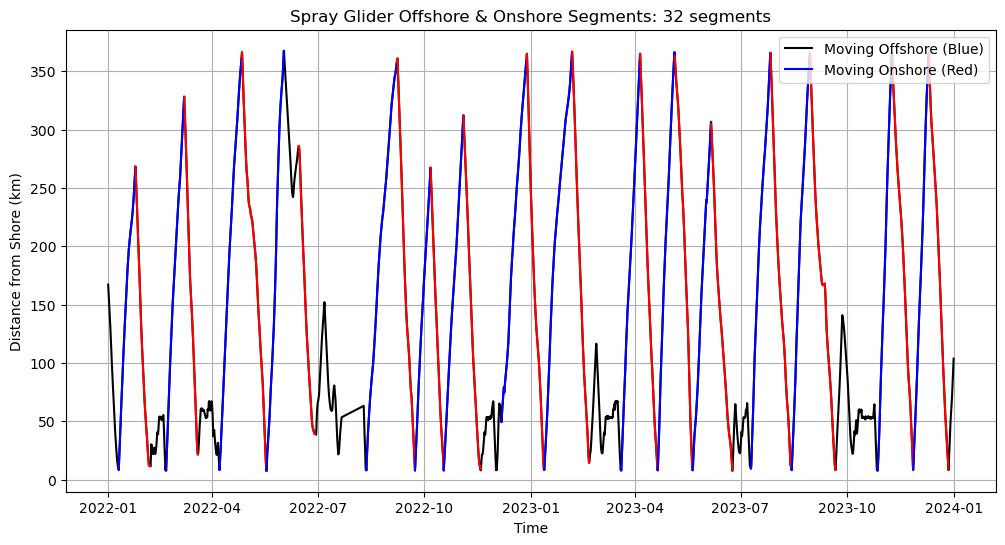

In [9]:
# Create figure 
fig = plt.figure(figsize=(12, 6))

# Plot the full glider trajectory 
plt.plot(time_dt,dist_t,'k-')

# Obtain unique segments 
unique_segments = np.unique(segment_labels)

# Loop through segments 
for seg in unique_segments:

    # Find indices of the ith segment
    seg_mask = segment_labels == seg

    # Set the color of the line based on the direction 
    color = "blue" if direction[mask][seg_mask][0] == 1 else "red"

    # Plot glider trajectory 
    plt.plot(time_seg[seg_mask], dist_seg[seg_mask], color=color)


# Set figure attributes 
plt.xlabel("Time")
plt.ylabel("Distance from Shore (km)")
plt.title("Spray Glider Offshore & Onshore Segments: " + str(len(unique_segments)) + ' segments')
plt.legend(["Moving Offshore (Blue)", "Moving Onshore (Red)"], loc="upper right")
plt.grid(True)
plt.show()

# Save figure 
fig.savefig(fname = PATH + '/figs/spray_glider/scale_analysis/onshore_offshore_segments_'  + years_d[0] + '_to_' + years_d[-1], bbox_inches = 'tight', dpi=300)

Compute off-shore and on-shore autocorrelation functions for each transect

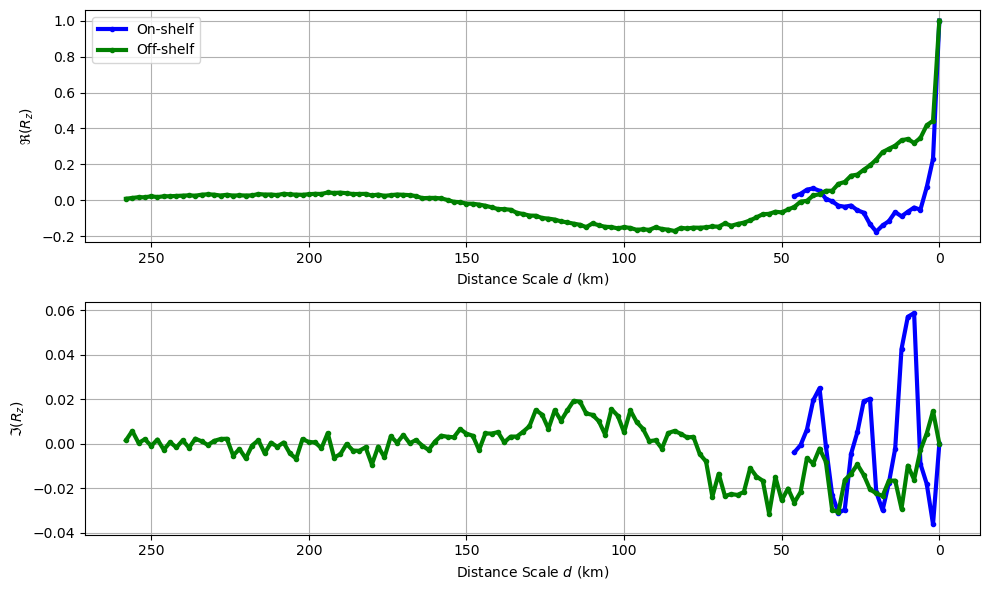

In [27]:
# Set parameters
L = 2
Nd_on = 50 
Nd_off = 300 
on_lim = -1000
off_lim = -3000
fontsize = 14
estimator = 'biased'
dirTransect = PATH + '/figs/spray_glider/Scale_analysis/depth_vel_depth_av_' + str(depth_lim) + '_' + estimator

# Counter
cn = 0 

# Obtain unique segments 
unique_segments = np.unique(segment_labels)

# Initialize arrays 
tau_re_on   = np.zeros_like(unique_segments)
tau_im_on   = np.zeros_like(unique_segments)
tau_re_off  = np.zeros_like(unique_segments)
tau_im_off  = np.zeros_like(unique_segments)
meanTime = []
sumAutoCorr_on  = np.zeros(int(Nd_on/L - 1), dtype=complex)
sumAutoCorr_off = np.zeros(int(Nd_off/L - 20), dtype=complex)
nAutoCorr_on    = np.zeros(int(Nd_on/L - 1))
nAutoCorr_off   = np.zeros(int(Nd_off/L - 20))

# Initialize characteristic scale vector for mean autocorrelation arrays
D_on = np.arange(0,Nd_on - L,L)
D_off = np.arange(0,Nd_off - 20*L,L)

# Loop through segments 
for seg in unique_segments:
    
    # Find indices of the ith segment
    seg_mask = segment_labels == seg

    # Obtain data for the ith segement 
    itime = time_seg[seg_mask]
    idist = dist_seg[seg_mask]
    iu = u_seg[seg_mask]
    iv = v_seg[seg_mask]
    iwater_depth = water_depth_seg[seg_mask]
    idirection = direction_seg[seg_mask]   

    # Set the direction (Moving Onshore = -1, Moving Offshore = 1)
    idir = stats.mode(idirection, keepdims=True).mode[0]

    # Convert to timestamps (numerical values in seconds)
    timestamps = np.array([dt.timestamp() for dt in itime])

    # Compute mean timestamp for segment
    mean_timestamp = np.mean(timestamps)

    # Convert back to datetime
    meanTime.append(datetime.fromtimestamp(mean_timestamp)) 

    # Compute autocorrelation functions for each transect
    autocorr_on, autocorr_off, tau_re_on[cn], tau_im_on[cn], tau_re_off[cn], tau_im_off[cn], dist_on, dist_off = compute_glider_autocorr_complex(idist, iu, iv, iwater_depth, L, on_lim, off_lim, idir, estimator)

    # Compute the sum and counter array of the autocorrelation function for onshore and offshore 
    dist_ref_on = np.round(dist_on-dist_on[0],0)
    dist_ref_off = np.round(dist_off-dist_off[0],0)
    _, idx_D_on, idx_dist_on = np.intersect1d(D_on, dist_ref_on, return_indices=True) 
    _, idx_D_off, idx_dist_off = np.intersect1d(D_off, dist_ref_off, return_indices=True) 
    sumAutoCorr_on[idx_D_on] += autocorr_on[idx_dist_on]
    sumAutoCorr_off[idx_D_off] += autocorr_off[idx_dist_off]
    nAutoCorr_on[idx_D_on] += 1
    nAutoCorr_off[idx_D_off] += 1

    # Reinitialize counter
    cn += 1

# Compute the mean autocorrelation function 
meanAutoCorr_on = sumAutoCorr_on/nAutoCorr_on
meanAutoCorr_off = sumAutoCorr_off/nAutoCorr_off

# Create figure
fig, axes = plt.subplots(2, 1, figsize=(10, 6))

#--- Subplot #1 ---# 

# Plot the real part of the mean autocorrelation functions 
axes[0].plot(D_on,meanAutoCorr_on.real, 'b.-', linewidth=3)
axes[0].plot(D_off,meanAutoCorr_off.real, 'g.-', linewidth=3)

# Set axis attributes
axes[0].set_xlabel(r"Distance Scale $d$ (km)")
axes[0].set_ylabel(r"$\Re(R_{z})$")
#axes[0].set_xlim(0,50)
#axes[0].set_ylim(-1.25,1.25)
axes[0].grid()
axes[0].legend(["On-shelf", "Off-shelf"], loc="upper left")

# Reverse the direction of the x-axis 
axes[0].invert_xaxis() 

#--- Subplot #2 ---# 

# Plot the imaginary part of the mean autocorrelation function 
axes[1].plot(D_on,meanAutoCorr_on.imag, 'b.-', linewidth=3)
axes[1].plot(D_off,meanAutoCorr_off.imag, 'g.-', linewidth=3)

# Set axis attributes
axes[1].set_xlabel(r"Distance Scale $d$ (km)")
axes[1].set_ylabel(r"$\Im(R_{z})$")
#axes[1].set_xlim(0,50)
#axes[1].set_ylim(-1.25,1.25)
axes[1].grid()

# Reverse the direction of the x-axis 
axes[1].invert_xaxis() 

# Display figure
plt.tight_layout()
plt.show()

# Save figure 
fig.savefig(fname = PATH + '/figs/spray_glider/scale_analysis/autocorr_vel_depth_av_' + str(depth_lim) + '_' + estimator, bbox_inches = 'tight', dpi=300)

# Convert meanTime into a numpy array 
meanTime = np.array(meanTime)

# Compute the mean decorrelation spatial scale 
tau_on_re_m = np.mean(tau_re_on)
tau_off_re_m = np.mean(tau_re_off)
tau_on_im_m = np.mean(tau_im_on)
tau_off_im_m = np.mean(tau_im_off)

Compute the uncertainty in the mean autocorrelation function

In [41]:
# Initialize arrays 
squareDiffAC_on_re  = np.zeros(int(Nd_on/L - 1),dtype=complex)
squareDiffAC_off_re = np.zeros(int(Nd_off/L - 20),dtype=complex)
squareDiffAC_on_im  = np.zeros(int(Nd_on/L - 1),dtype=complex)
squareDiffAC_off_im = np.zeros(int(Nd_off/L - 20),dtype=complex)

# Define the real and imaginary parts of the autocorrelation function 
mcoef_pos_on_re = meanAutoCorr_on.real
mcoef_pos_on_im = meanAutoCorr_on.imag
mcoef_pos_off_re = meanAutoCorr_off.real
mcoef_pos_off_im = meanAutoCorr_off.imag

# Loop through segments
for seg in unique_segments:

    # Find indices of the ith segment
    seg_mask = segment_labels == seg

    # Obtain data for the ith segement 
    itime = time_seg[seg_mask]
    idist = dist_seg[seg_mask]
    iu = u_seg[seg_mask]
    iv = v_seg[seg_mask]
    iwater_depth = water_depth_seg[seg_mask]
    idirection = direction_seg[seg_mask]

    # Set the direction (Moving Onshore = -1, Moving Offshore = 1)
    idir = stats.mode(idirection, keepdims=True).mode[0]

    # Compute autocorrelation functions for each transect
    autocorr_on, autocorr_off, _, _, _, _, dist_on, dist_off = compute_glider_autocorr_complex(idist, iu, iv, iwater_depth, L, on_lim, off_lim, idir, estimator)

    # Find the indices of the lags which intersect with the lag grid vector I generated to compute the 
    # mean autocorrelation function 
    dist_ref_on = np.round(dist_on-dist_on[0],0)
    dist_ref_off = np.round(dist_off-dist_off[0],0)
    _, idx_D_on, idx_dist_on = np.intersect1d(D_on, dist_ref_on, return_indices=True) 
    _, idx_D_off, idx_dist_off = np.intersect1d(D_off, dist_ref_off, return_indices=True) 

    # Define the real and imaginary parts of the autocorrelation function 
    coef_pos_on_re = autocorr_on.real
    coef_pos_on_im = autocorr_on.imag
    coef_pos_off_re = autocorr_off.real
    coef_pos_off_im = autocorr_off.imag
    
    # Compute the sum of the squared difference from the mean at each lag for the real and imaginary parts 
    squareDiffAC_on_re[idx_D_on]  += (coef_pos_on_re[idx_dist_on] - mcoef_pos_on_re[idx_dist_on])**2
    squareDiffAC_off_re[idx_D_off] += (coef_pos_off_re[idx_dist_off] - mcoef_pos_off_re[idx_dist_off])**2
    squareDiffAC_on_im[idx_D_on]  += (coef_pos_on_im[idx_dist_on] - mcoef_pos_on_im[idx_dist_on])**2
    squareDiffAC_off_im[idx_D_off] += (coef_pos_off_im[idx_dist_off] - mcoef_pos_off_im[idx_dist_off])**2


# Compute the sample standard deviation of the autocorrelation function 
stdAutoCorr_on_re = np.sqrt((1/(nAutoCorr_on - 1)) * squareDiffAC_on_re)
stdAutoCorr_off_re = np.sqrt((1/(nAutoCorr_off - 1)) * squareDiffAC_off_re)
stdAutoCorr_on_im = np.sqrt((1/(nAutoCorr_on - 1)) * squareDiffAC_on_im)
stdAutoCorr_off_im = np.sqrt((1/(nAutoCorr_off - 1)) * squareDiffAC_off_im)

# Compute the standard error of the mean for the mean autocorrelation function (assuming we have independent estimates from each autocorrelation function from each segment)
stdmAutoCorr_on_re = stdAutoCorr_on_re/np.sqrt(nAutoCorr_on)
stdmAutoCorr_off_re = stdAutoCorr_off_re/np.sqrt(nAutoCorr_off)
stdmAutoCorr_on_im = stdAutoCorr_on_im/np.sqrt(nAutoCorr_on)
stdmAutoCorr_off_im = stdAutoCorr_off_im/np.sqrt(nAutoCorr_off)

Plot the average autocorrelation function with error bars

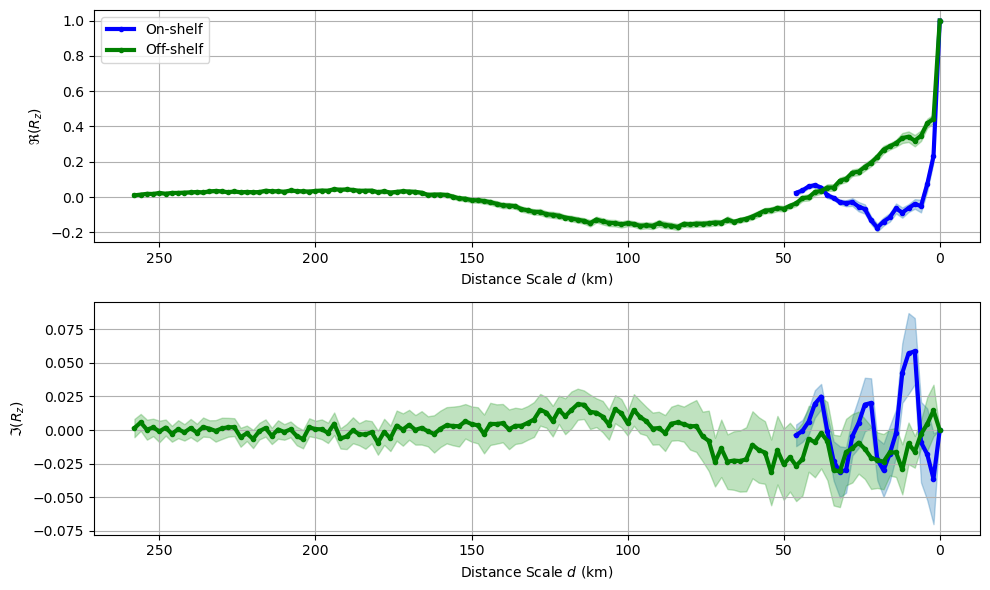

In [46]:
# Create figure
fig, axes = plt.subplots(2, 1, figsize=(10, 6))

#--- Subplot #1 ---# 

# Plot the real part of the mean autocorrelation functions 
axes[0].plot(D_on,meanAutoCorr_on.real, 'b.-', linewidth=3)
axes[0].plot(D_off,meanAutoCorr_off.real, 'g.-', linewidth=3)

# Plot the error bars of the mean autocorrelation function 
axes[0].fill_between(D_on,meanAutoCorr_on.real - stdmAutoCorr_on_re,meanAutoCorr_on.real + stdmAutoCorr_on_re,color="tab:blue",alpha=0.3)
axes[0].fill_between(D_off,meanAutoCorr_off.real - stdmAutoCorr_off_re,meanAutoCorr_off.real + stdmAutoCorr_off_re,color="tab:green",alpha=0.3)

# Set axis attributes
axes[0].set_xlabel(r"Distance Scale $d$ (km)")
axes[0].set_ylabel(r"$\Re(R_{z})$")
#axes[0].set_xlim(0,50)
#axes[0].set_ylim(-1.25,1.25)
axes[0].grid()
axes[0].legend(["On-shelf", "Off-shelf"], loc="upper left")

# Reverse the direction of the x-axis 
axes[0].invert_xaxis() 

#--- Subplot #2 ---# 

# Plot the imaginary part of the mean autocorrelation function 
axes[1].plot(D_on,meanAutoCorr_on.imag, 'b.-', linewidth=3)
axes[1].plot(D_off,meanAutoCorr_off.imag, 'g.-', linewidth=3)

# Plot the error bars of the mean autocorrelation function 
axes[1].fill_between(D_on,meanAutoCorr_on.imag - stdmAutoCorr_on_im,meanAutoCorr_on.imag + stdmAutoCorr_on_im,color="tab:blue",alpha=0.3)
axes[1].fill_between(D_off,meanAutoCorr_off.imag - stdmAutoCorr_off_im,meanAutoCorr_off.imag + stdmAutoCorr_off_im,color="tab:green",alpha=0.3)

# Set axis attributes
axes[1].set_xlabel(r"Distance Scale $d$ (km)")
axes[1].set_ylabel(r"$\Im(R_{z})$")
#axes[1].set_xlim(0,50)
#axes[1].set_ylim(-1.25,1.25)
axes[1].grid()

# Reverse the direction of the x-axis 
axes[1].invert_xaxis() 

# Display figure
plt.tight_layout()
plt.show()

# Save figure 
fig.savefig(fname = PATH + '/figs/spray_glider/scale_analysis/autocorr_vel_depth_av_' + str(depth_lim) + '_' + estimator, bbox_inches = 'tight', dpi=300)

Compute the decorrelation scale from the mean autocorrelation function

In [34]:
#--- Onshore ---# 

# Create the negative lagged meant autocovariance function
meanAutoCorr_on_pos = meanAutoCorr_on
meanAutoCorr_on_neg = np.flip(meanAutoCorr_on)[:-1]

# Define the real and imaginary parts of the autocorrelation function 
coef_pos_re = meanAutoCorr_on_pos.real
coef_neg_re = meanAutoCorr_on_neg.real
coef_pos_im = meanAutoCorr_on_pos.imag
coef_neg_im = meanAutoCorr_on_neg.imag

# Set the length of data series and data interval
N = len(coef_pos_re)  # length of one-sided autocorrelation function
R = N * L                 # length of the data series

# Initialize scale_N variable
scale_N_re = np.zeros(N)
scale_N_im = np.zeros(N)

# Loop through 
for i in range(N):

    # Index autocorrelation function 

    #--- Zeroth lag ---# 
    if i == 0:

        # Set interal of the autocorrelation function to zero (intergration range vanishes)
        iscale_re = 0 
        iscale_im = 0  

    #--- Higher Order lag ---#     
    else:

        # Index the autocorrelation function and combine the negative and positive lagged autocorrelation functions 
        coef_re = np.concatenate((coef_neg_re[N-i-1:], coef_pos_re[:i+1]))
        coef_im = np.concatenate((coef_neg_im[N-i-1:], coef_pos_im[:i+1]))

        # Compute spatial lag
        r = i * L

        # Compute integral of autocorrelation function 
        iscale_re = trapezoid((1 - (r / R)) * coef_re, dx=L)
        iscale_im = trapezoid((1 - (r / R)) * coef_im, dx=L)
    
    # Save the ith scaling factor
    scale_N_re[i] = iscale_re
    scale_N_im[i] = iscale_im

# Find the maximum decorrelation time scale (conservative estimate)
tau_re_on_mA = np.nanmax(scale_N_re)
tau_im_on_mA = np.nanmax(scale_N_im)

#--- Offshore ---# 

# Create the negative lagged meant autocovariance function
meanAutoCorr_off_pos = meanAutoCorr_off
meanAutoCorr_off_neg = np.flip(meanAutoCorr_off)[:-1]

# Define the real and imaginary parts of the autocorrelation function 
coef_pos_re = meanAutoCorr_off_pos.real
coef_neg_re = meanAutoCorr_off_neg.real
coef_pos_im = meanAutoCorr_off_pos.imag
coef_neg_im = meanAutoCorr_off_neg.imag

# Set the length of data series and data interval
N = len(coef_pos_re)  # length of one-sided autocorrelation function
R = N * L                 # length of the data series

# Initialize scale_N variable
scale_N_re = np.zeros(N)
scale_N_im = np.zeros(N)

# Loop through 
for i in range(N):

    # Index autocorrelation function 

    #--- Zeroth lag ---# 
    if i == 0:

        # Set interal of the autocorrelation function to zero (intergration range vanishes)
        iscale_re = 0 
        iscale_im = 0 

    #--- Higher Order lag ---#     
    else:

        # Index the autocorrelation function and combine the negative and positive lagged autocorrelation functions 
        coef_re = np.concatenate((coef_neg_re[N-i-1:], coef_pos_re[:i+1]))
        coef_im = np.concatenate((coef_neg_im[N-i-1:], coef_pos_im[:i+1]))

        # Compute spatial lag
        r = i * L

        # Compute integral of autocorrelation function 
        iscale_re = trapezoid((1 - (r / R)) * coef_re, dx=L)
        iscale_im = trapezoid((1 - (r / R)) * coef_im, dx=L)
    
    # Save the ith scaling factor
    scale_N_re[i] = iscale_re
    scale_N_im[i] = iscale_im

# Find the maximum decorrelation time scale (conservative estimate)
tau_re_off_mA = np.nanmax(scale_N_re)
tau_im_off_mA = np.nanmax(scale_N_im)

Plot the decorrelation time scale for each segment

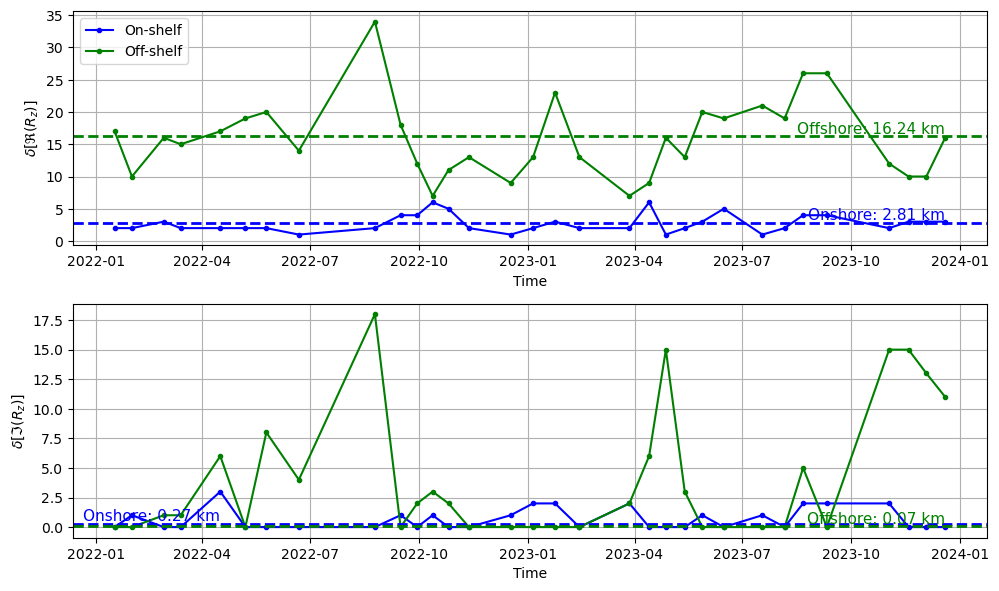

In [39]:
# Create figure
fig, axes = plt.subplots(2, 1, figsize=(10, 6))

#--- Subplot #1 ---# 

# Plot the decorrelation scale from the real part of the autocorrelation function
axes[0].plot(meanTime,tau_re_on,'b.-')
axes[0].plot(meanTime,tau_re_off,'g.-')

# Plot on and off-shelf limits
axes[0].axhline(tau_re_on_mA, color='b', linestyle='--', linewidth=2)
axes[0].axhline(tau_re_off_mA, color='g', linestyle='--', linewidth=2)

# Add label text near the vertical lines
axes[0].text(meanTime[-1],tau_re_on_mA, r'Onshore: ' + str(np.round(tau_re_on_mA,2)) + ' km', color='b', fontsize=fontsize-3, ha='right',va='bottom',rotation=0) 
axes[0].text(meanTime[-1],tau_re_off_mA, r'Offshore: ' + str(np.round(tau_re_off_mA,2)) + ' km', color='g', fontsize=fontsize-3, ha='right',va='bottom',rotation=0)

# Set axis attributes
axes[0].set_xlabel(r"Time")
axes[0].set_ylabel(r"$\delta[\Re(R_{z})]$")
axes[0].grid()
axes[0].legend(["On-shelf","Off-shelf"], loc="upper left")

#--- Subplot #2 ---# 

# Plot the decorrelation scale
axes[1].plot(meanTime,tau_im_on,'b.-')
axes[1].plot(meanTime,tau_im_off,'g.-')

# Plot on and off-shelf limits
axes[1].axhline(tau_im_on_mA, color='b', linestyle='--', linewidth=2)
axes[1].axhline(tau_im_off_mA, color='g', linestyle='--', linewidth=2)

# Add label text near the vertical lines
axes[1].text(meanTime[4],tau_im_on_mA, r'Onshore: ' + str(np.round(tau_im_on_mA,2)) + ' km', color='b', fontsize=fontsize-3, ha='right',va='bottom',rotation=0) 
axes[1].text(meanTime[-1],tau_im_off_mA, r'Offshore: ' + str(np.round(tau_im_off_mA,2)) + ' km', color='g', fontsize=fontsize-3, ha='right',va='bottom',rotation=0)

# Set axis attributes
axes[1].set_xlabel(r"Time")
axes[1].set_ylabel(r"$\delta[\Im(R_{z})]$")
axes[1].grid()

# Display figure
plt.tight_layout()
plt.show()

# Save figure 
fig.savefig(fname = PATH + '/figs/spray_glider/scale_analysis/decor_scale_vel_depth_av_' + str(depth_lim) + '_' + estimator, bbox_inches = 'tight', dpi=300)

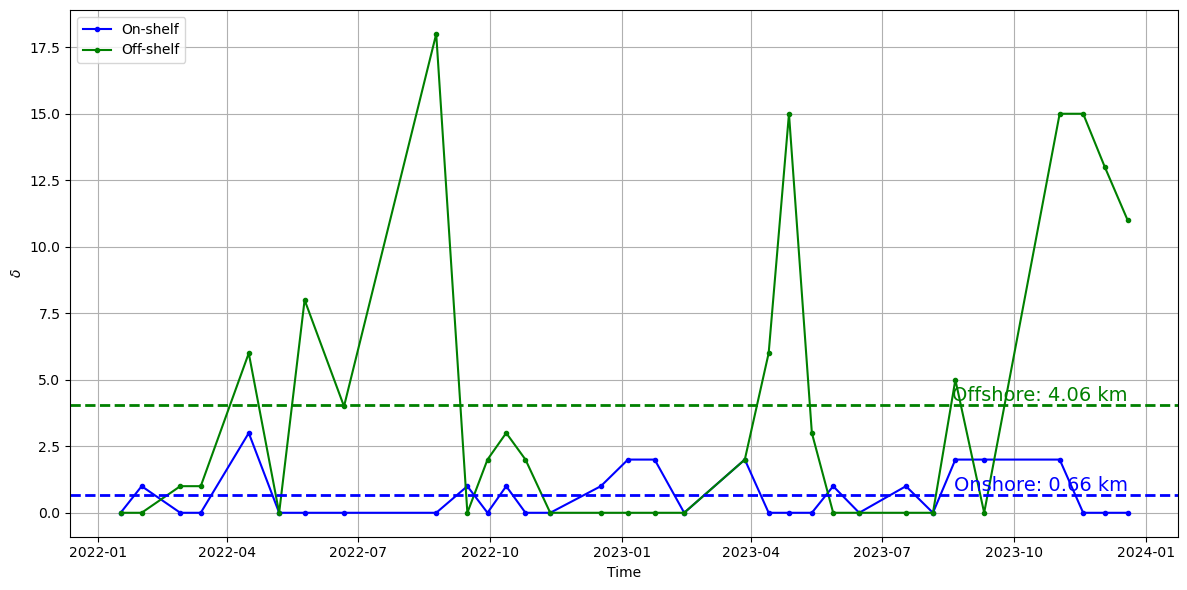

In [12]:
# Create figure 
fig = plt.figure(figsize=(12, 6))

# Plot the decorrelation scale
plt.plot(meanTime,tau_im_on,'b.-')
plt.plot(meanTime,tau_im_off,'g.-')

# Plot on and off-shelf limits
plt.axhline(tau_on_im_m, color='b', linestyle='--', linewidth=2)
plt.axhline(tau_off_im_m, color='g', linestyle='--', linewidth=2)

# Add label text near the vertical lines
plt.text(meanTime[-1],tau_on_im_m, r'Onshore: ' + str(np.round(tau_on_im_m,2)) + ' km', color='b', fontsize=fontsize, ha='right',va='bottom',rotation=0) 
plt.text(meanTime[-1],tau_off_im_m, r'Offshore: ' + str(np.round(tau_off_im_m,2)) + ' km', color='g', fontsize=fontsize, ha='right',va='bottom',rotation=0)

# Set axis attributes
plt.xlabel(r"Time")
plt.ylabel(r"$\delta$")
plt.grid()
plt.legend(["On-shelf","Off-shelf"], loc="upper left")

# Display figure
plt.tight_layout()
plt.show()

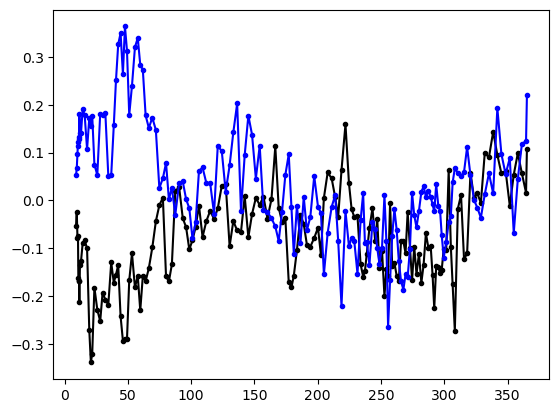

In [13]:
plt.plot(idist,iu,'k.-')
plt.plot(idist,iv,'b.-')
plt.show()